# Training on data such that there are 150 events with n tracks for n in [1,50].
# Testing on data such that there are 25 events with n tracks for n in [1,50].

In [ ]:
!nvidia-smi

In [1]:
# Author: Daniel Zurawski
# Author: Keshav Kapoor
# Organization: Fermilab
# Grammar: Python 3.6.1

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

### Choose either (1) or (2).
### (1) If you prefer a separate window for plots, uncomment the below.
#import matplotlib
#matplotlib.use('qt5agg')

### (2) If you prefer plots to display within the notebook, uncomment the below.
### WARNING: Plots suffer performance issues and will lag a bit.
%matplotlib notebook

import importlib
import keras # Neural network models
import pandas as pd # Data frames
import numpy as np  # numerical python
from tracker3d import loader, utils, metrics

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0E:00.0)


In [2]:
order   = ("r", "phi", "z")
n_noise = 0
code    = (order[0][0] + order[1][0] + order[2][0]).upper()
file    = "datasets/npz/UNIF-50T-175E-{0}-{1}N.npz".format(code, n_noise)

load_from_file = True

if load_from_file:
    data, target = loader.from_file(file)
else:
    data, target = loader.from_frame(
        frame=pd.read_csv("datasets/raw/UNIF-50T-175E.csv"),
        order=order,
        n_noise=n_noise
    )
    permutation  = np.random.permutation(data.shape[0])
    data   = data[permutation]
    target = target[permutation]
    loader.to_file(data, target, file)
    
percent = 6/7  # What percent of the data should be used to train with.
bound   = int(data.shape[0] * percent)
train_data, train_target = data[:bound], target[:bound]
test_data,  test_target  = data[bound:], target[bound:]
print("Successfully loaded!")
print("train_data shape:   {0},\ntrain_target shape: {1}".format(train_data.shape, train_target.shape))
print("test_data shape:    {0},\ntest_target shape:  {1}".format(test_data.shape, test_target.shape))

Successfully loaded!
train_data shape:   (7500, 437, 3),
train_target shape: (7500, 437, 52)
test_data shape:    (1250, 437, 3),
test_target shape:  (1250, 437, 52)


In [3]:
# To be used when we define our model.
from keras.layers import TimeDistributed, Dense, LSTM, Activation
from keras.layers import Dropout, GRU, Bidirectional, Conv2D, Conv1D
from keras.layers import MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2, l1
from keras.models import Sequential

In [4]:
# It is time to define parameters for the model.
input_shape  = train_data.shape[1:] # Shape of an event.
num_classes  = train_target.shape[2] # Number of tracks per event
valsplit     = 1/8
opt          = keras.optimizers.RMSprop(lr=0.001)

In [5]:
model = keras.models.load_model("models/TRAIN-U50T150E-TEST-U50T25E-RPZ-0N.h5")

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [ ]:
###############
# Input Layer #
###############
model = Sequential()
model.add(Dropout(rate=1/8, input_shape=input_shape))

#################
# Hidden Layers #
#################
for _ in range(3):
    model.add(Bidirectional(
        GRU(
            units=300, 
            return_sequences=True,
            recurrent_dropout=1/8,
            #activation="tanh",
            dropout=1/8,
            implementation=2
        ),
        merge_mode="concat"
    ))
################
# Output Layer #
################
model.add(TimeDistributed(Dense(
    units=num_classes, 
    kernel_initializer="uniform", 
    activation="softmax"
)))

###############
# Compilation #
###############
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

# Print a summary of the model.
print("Epochs: {0}, Batch Size: {1}, Validation Split {2}%".format(
    epochs,
    batch_size,
    valsplit * 100
))
model.summary()

In [ ]:
%%time

epochs       = 256
batch_size   = 64

hist = model.fit (
    train_data,
    train_target,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_split=valsplit,
    callbacks=[keras.callbacks.ModelCheckpoint(
        filepath="models/TRAIN-U50T150E-TEST-U50T25E-{0}-{1}N.h5".format(code, n_noise),
        period=4
    )]
)
model.save("models/TRAIN-U50T150E-TEST-U50T25E-{0}-{1}N.h5".format(code, n_noise))

In [6]:
guesses = model.predict(test_data)

<IPython.core.display.Javascript object>


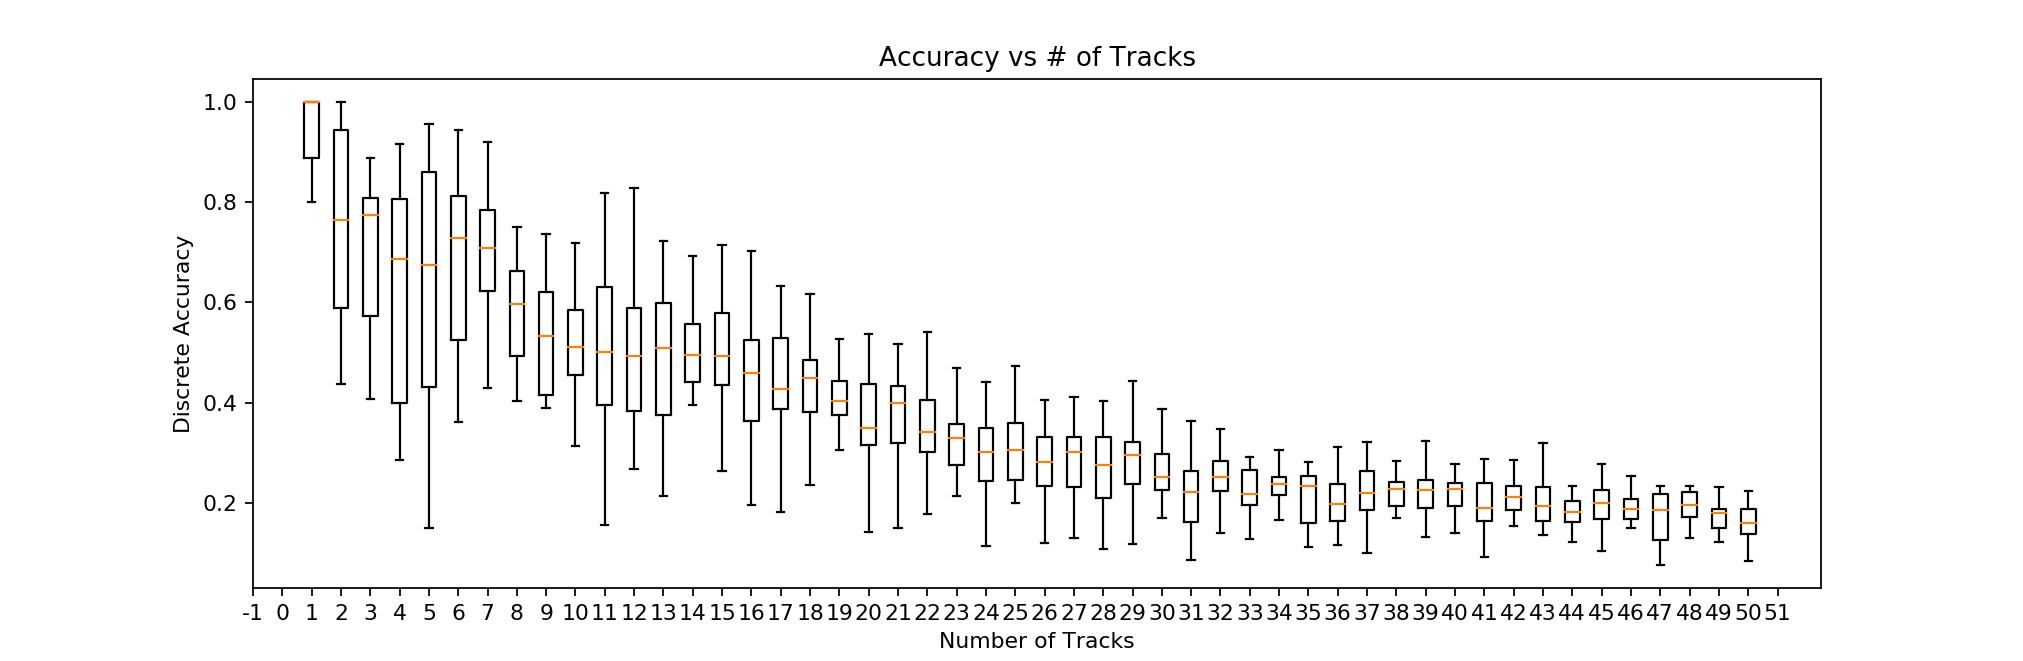

<IPython.core.display.Javascript object>


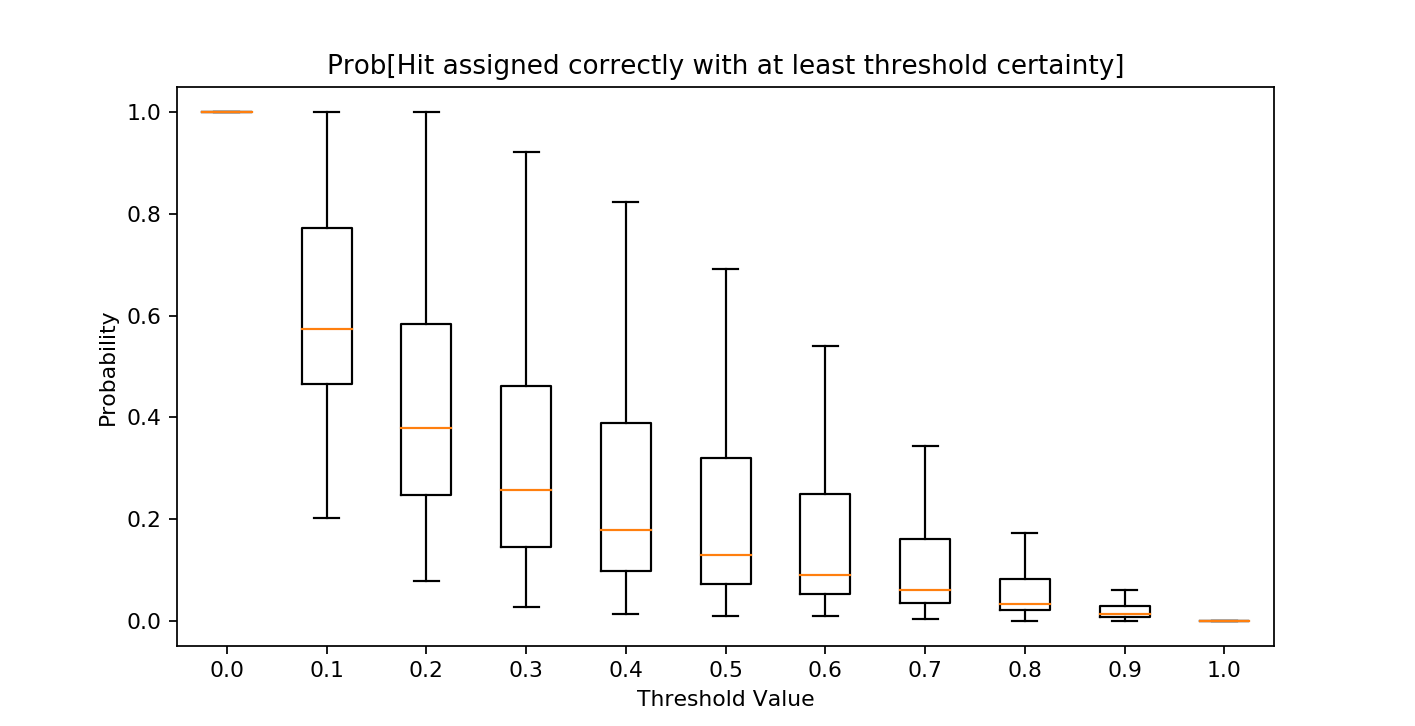

<IPython.core.display.Javascript object>


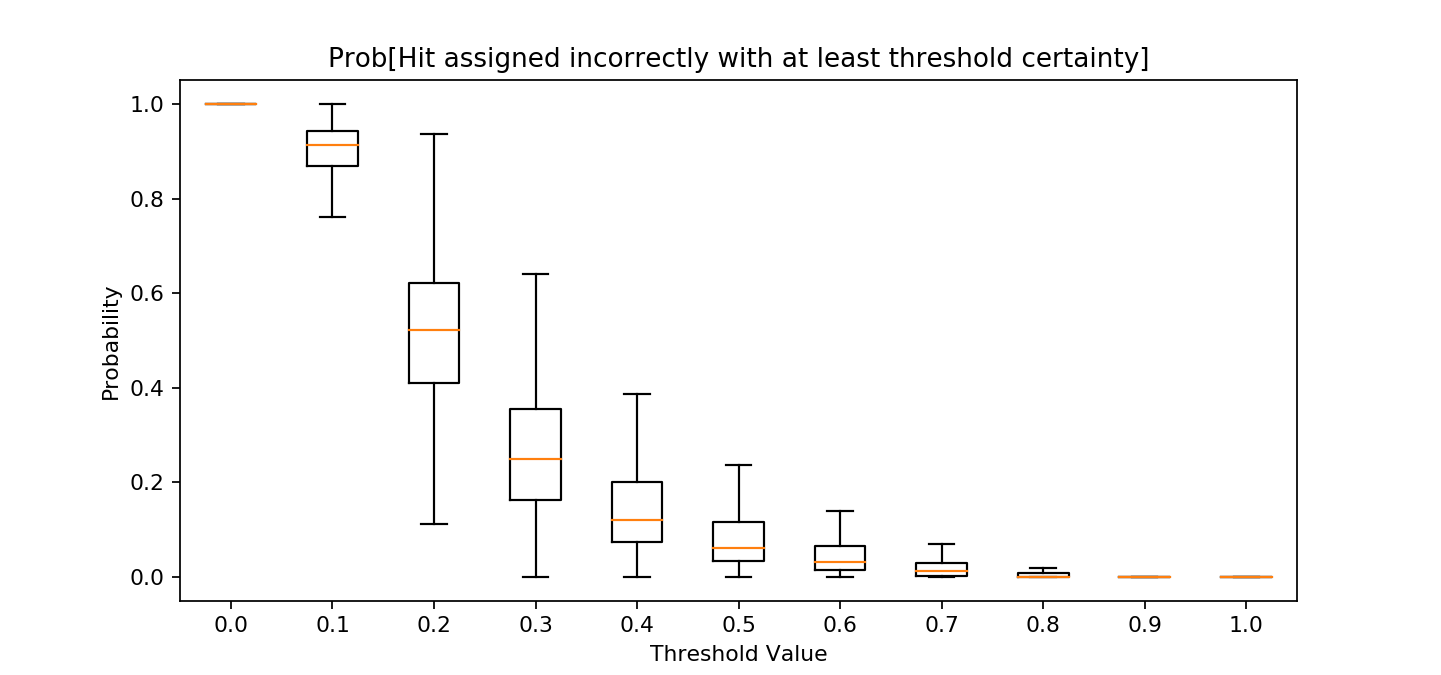

<IPython.core.display.Javascript object>


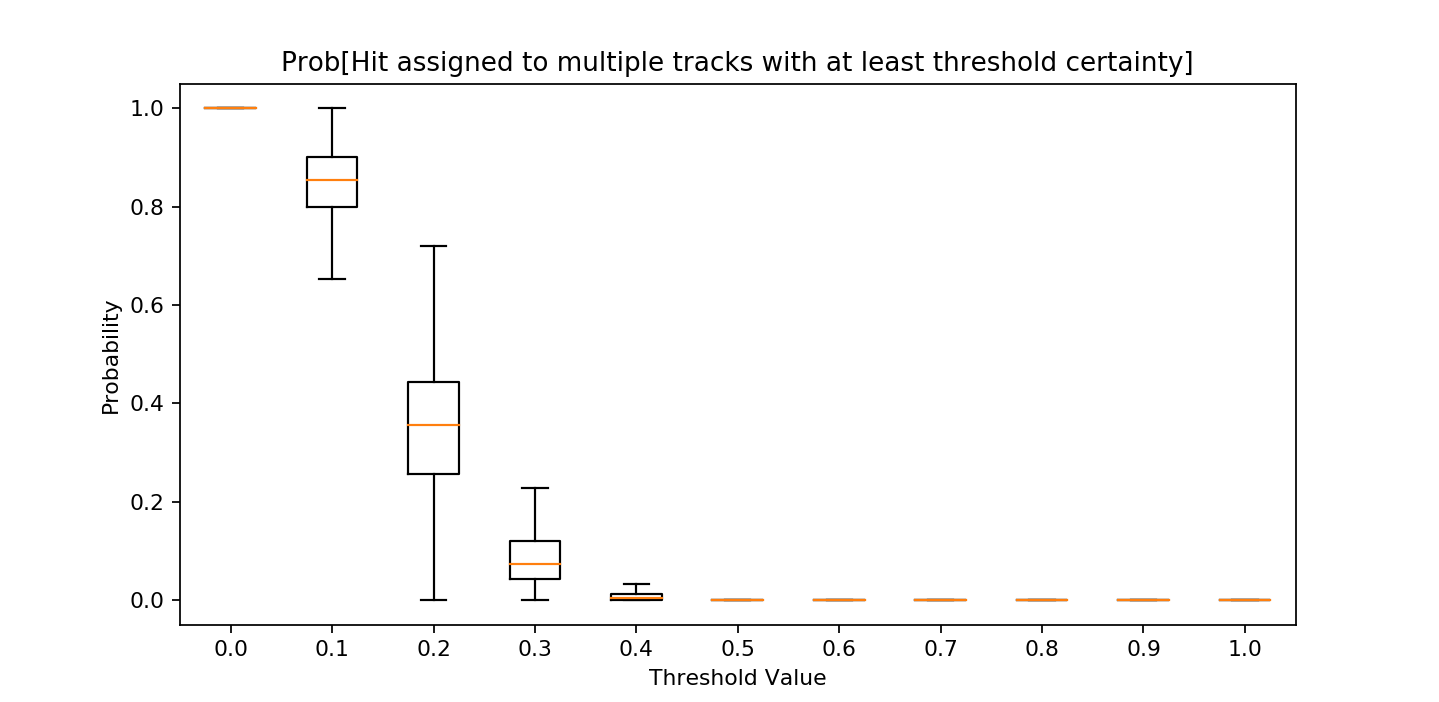

<IPython.core.display.Javascript object>


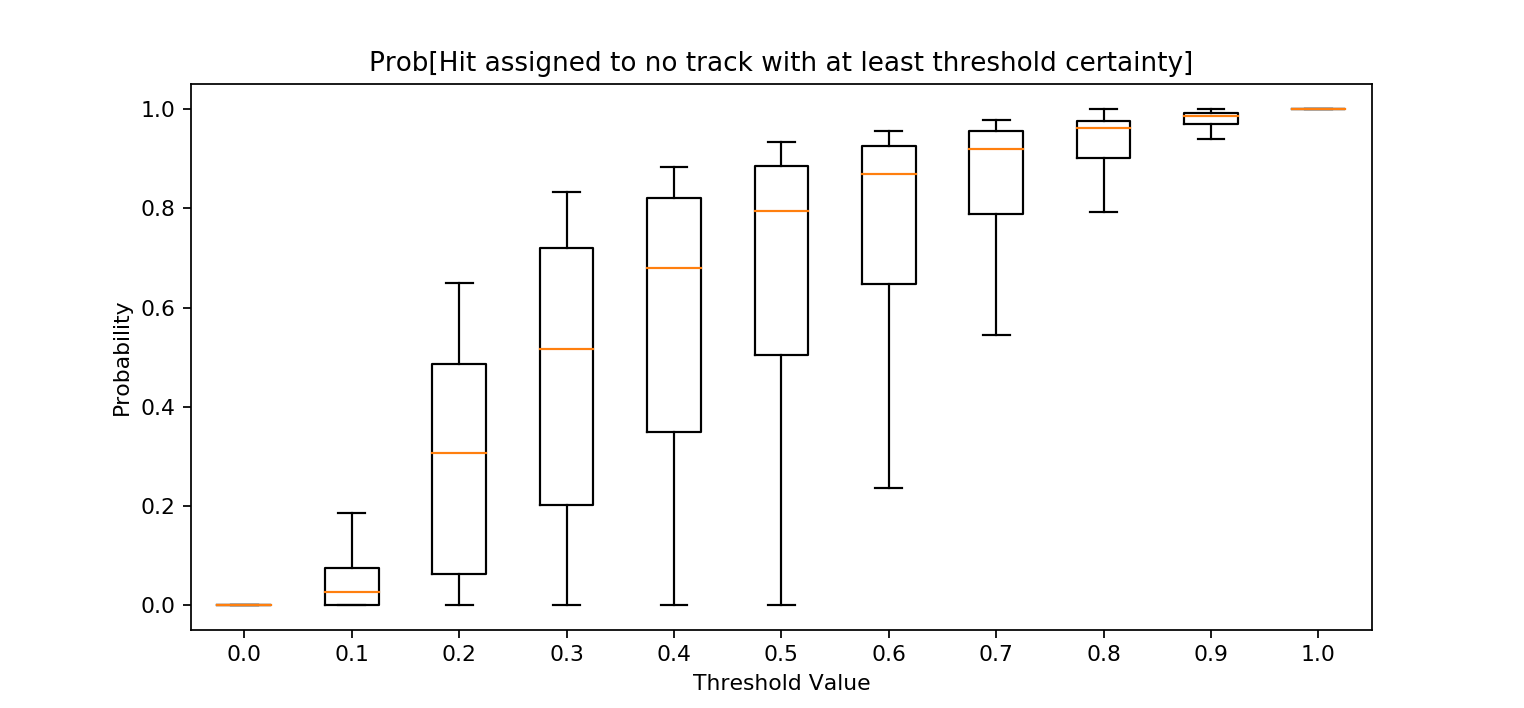

In [7]:
thresholds = [i / 10 for i in range(0, 1 + 10)]
_ = metrics.accuracy_vs_tracks_boxplot(guesses, test_target, noise=(n_noise > 0))
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="correct")
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="incorrect")
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="many")
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="none")